# HAI-21.03 Dataset Exploration

This notebook explores the HAI-21.03 industrial control system security dataset.

In [1]:
# Import required libraries
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('ggplot')
sns.set(style="darkgrid")

# Set random seeds for reproducibility
np.random.seed(42)

## 1. Global Variables Setup

In [2]:
# Set paths
DATA_DIR = '../hai-security-dataset/hai-21.03'
OUTPUT_DIR = '../hai-security-dataset/processed'

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

## 2. Data Loading

In [3]:
# Define a simple data loader class
class HAIDataLoader:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.train_files = glob.glob(os.path.join(data_dir, 'train*.csv'))
        self.test_files = glob.glob(os.path.join(data_dir, 'test*.csv'))
        self.train_data = {}
        self.test_data = {}
        
        print(f"Found {len(self.train_files)} train files and {len(self.test_files)} test files")
    
    def _preprocess_dataframe(self, df):
        # Convert column names to lowercase for consistency
        df.columns = [col.lower() for col in df.columns]
        
        # Handle missing values
        df = df.fillna(method='ffill').fillna(method='bfill')
        
        # Ensure attack column exists (it might not in training data)
        if 'attack' not in df.columns:
            df['attack'] = 0
        
        return df
    
    def load_data(self):
        # Load training files
        print("Loading train files:")
        for file in self.train_files:
            file_name = os.path.basename(file).split('.')[0]
            df = pd.read_csv(file)
            df = self._preprocess_dataframe(df)
            self.train_data[file_name] = df
            print(f"  {file_name}: {df.shape[0]} rows, {df.shape[1]} columns")
        
        # Load test files
        print("\nLoading test files:")
        for file in self.test_files:
            file_name = os.path.basename(file).split('.')[0]
            df = pd.read_csv(file)
            df = self._preprocess_dataframe(df)
            self.test_data[file_name] = df
            print(f"  {file_name}: {df.shape[0]} rows, {df.shape[1]} columns")
    
    def merge_train_data(self):
        if not self.train_data:
            print("No training data loaded. Call load_data() first.")
            return None
        
        # Merge all training dataframes
        merged_df = pd.concat(list(self.train_data.values()), axis=0, ignore_index=True)
        print(f"Merged training data: {merged_df.shape[0]} rows, {merged_df.shape[1]} columns")
        
        return merged_df
    
    def merge_test_data(self):
        if not self.test_data:
            print("No test data loaded. Call load_data() first.")
            return None
        
        # Merge all test dataframes
        merged_df = pd.concat(list(self.test_data.values()), axis=0, ignore_index=True)
        print(f"Merged test data: {merged_df.shape[0]} rows, {merged_df.shape[1]} columns")
        
        return merged_df
    
    def get_feature_columns(self, df=None):
        if df is None:
            if not self.train_data:
                print("No training data loaded. Call load_data() first.")
                return []
            df = list(self.train_data.values())[0]
        
        # Get feature columns excluding time and attack columns
        feature_cols = [col for col in df.columns 
                       if not col.startswith('time') and not col.startswith('attack')]
        
        return feature_cols

In [4]:
# Initialize data loader
data_loader = HAIDataLoader(DATA_DIR)

# Load data
data_loader.load_data()

Found 3 train files and 5 test files
Loading train files:
  train1: 216001 rows, 84 columns
  train2: 226801 rows, 84 columns
  train3: 478801 rows, 84 columns

Loading test files:
  test1: 43201 rows, 84 columns
  test2: 118801 rows, 84 columns
  test3: 108001 rows, 84 columns
  test4: 39601 rows, 84 columns
  test5: 92401 rows, 84 columns


In [5]:
# Get all training data and merge
train_df = data_loader.merge_train_data()

# Print dataset information
print(f"Training data shape: {train_df.shape}")
print(f"Training data columns: {train_df.columns[:10].tolist()}...")

Merged training data: 921603 rows, 84 columns
Training data shape: (921603, 84)
Training data columns: ['time', 'p1_b2004', 'p1_b2016', 'p1_b3004', 'p1_b3005', 'p1_b4002', 'p1_b4005', 'p1_b400b', 'p1_b4022', 'p1_fcv01d']...


## 3. Data Exploration

In [6]:
# Get feature columns
feature_cols = data_loader.get_feature_columns(train_df)
print(f"Number of feature columns: {len(feature_cols)}")
print(f"First 10 feature columns: {feature_cols[:10]}")

Number of feature columns: 79
First 10 feature columns: ['p1_b2004', 'p1_b2016', 'p1_b3004', 'p1_b3005', 'p1_b4002', 'p1_b4005', 'p1_b400b', 'p1_b4022', 'p1_fcv01d', 'p1_fcv01z']


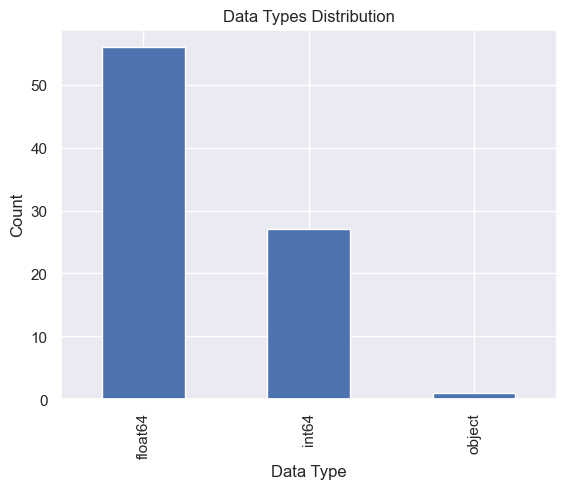

In [7]:
# Explore data types
train_df.dtypes.value_counts().plot(kind='bar')
plt.title('Data Types Distribution')
plt.xlabel('Data Type')
plt.ylabel('Count')
plt.show()

In [8]:
# Explore missing values
missing_values = train_df.isnull().sum()
missing_values = missing_values[missing_values > 0]

if len(missing_values) > 0:
    plt.figure(figsize=(10, 6))
    missing_values.plot(kind='bar')
    plt.title('Missing Values by Column')
    plt.xlabel('Column')
    plt.ylabel('Count')
    plt.show()
else:
    print("No missing values found in the dataset.")

No missing values found in the dataset.


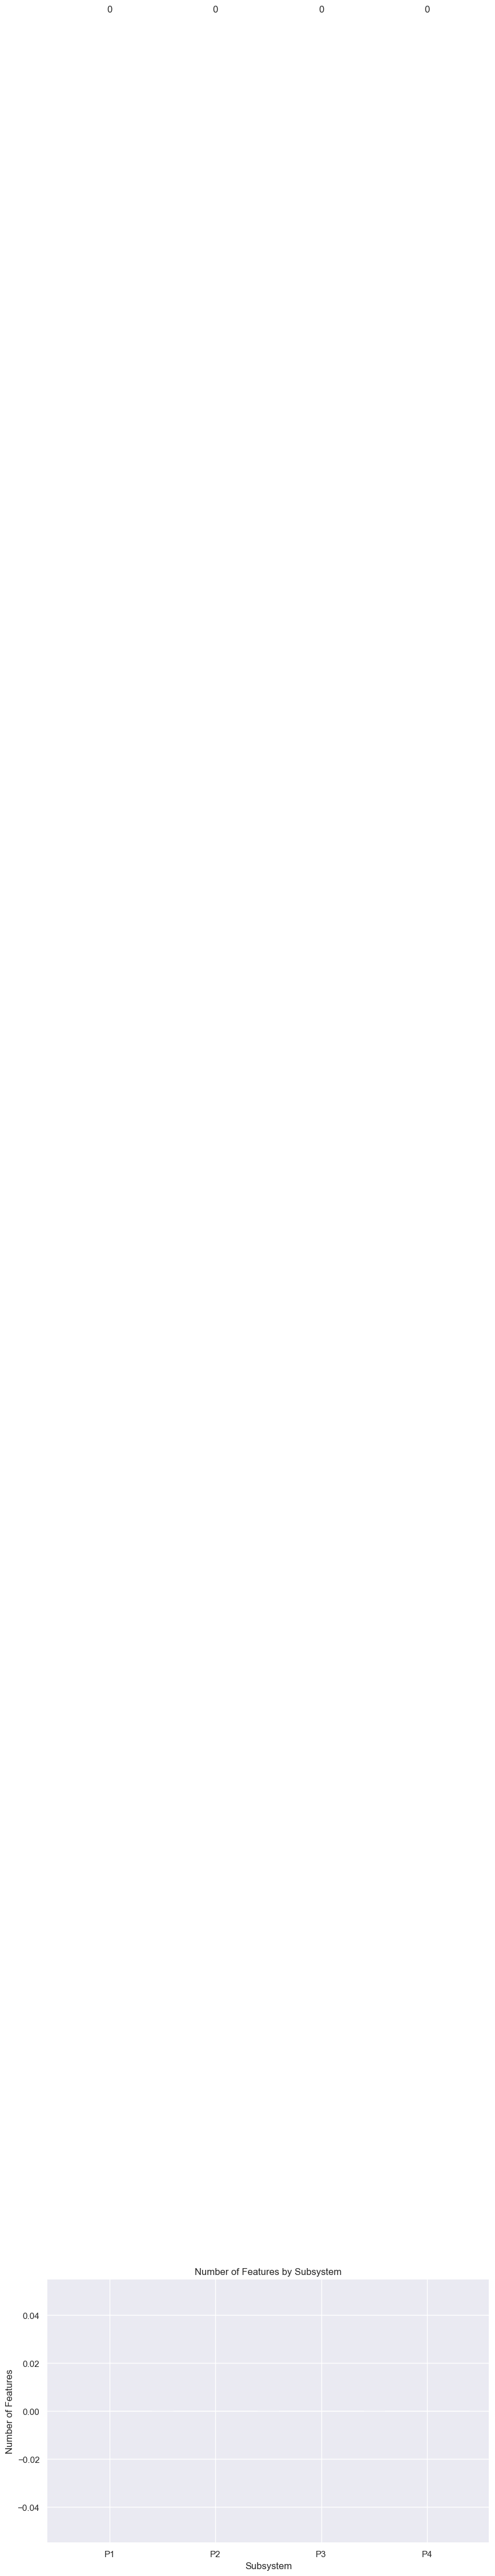

In [9]:
# Explore subsystems
subsystems = ['P1', 'P2', 'P3', 'P4']
subsystem_counts = {}

for subsystem in subsystems:
    subsystem_cols = [col for col in feature_cols if col.startswith(f"{subsystem}_")]
    subsystem_counts[subsystem] = len(subsystem_cols)

plt.figure(figsize=(10, 6))
plt.bar(subsystem_counts.keys(), subsystem_counts.values())
plt.title('Number of Features by Subsystem')
plt.xlabel('Subsystem')
plt.ylabel('Number of Features')
for i, (subsystem, count) in enumerate(subsystem_counts.items()):
    plt.text(i, count + 1, str(count), ha='center')
plt.show()

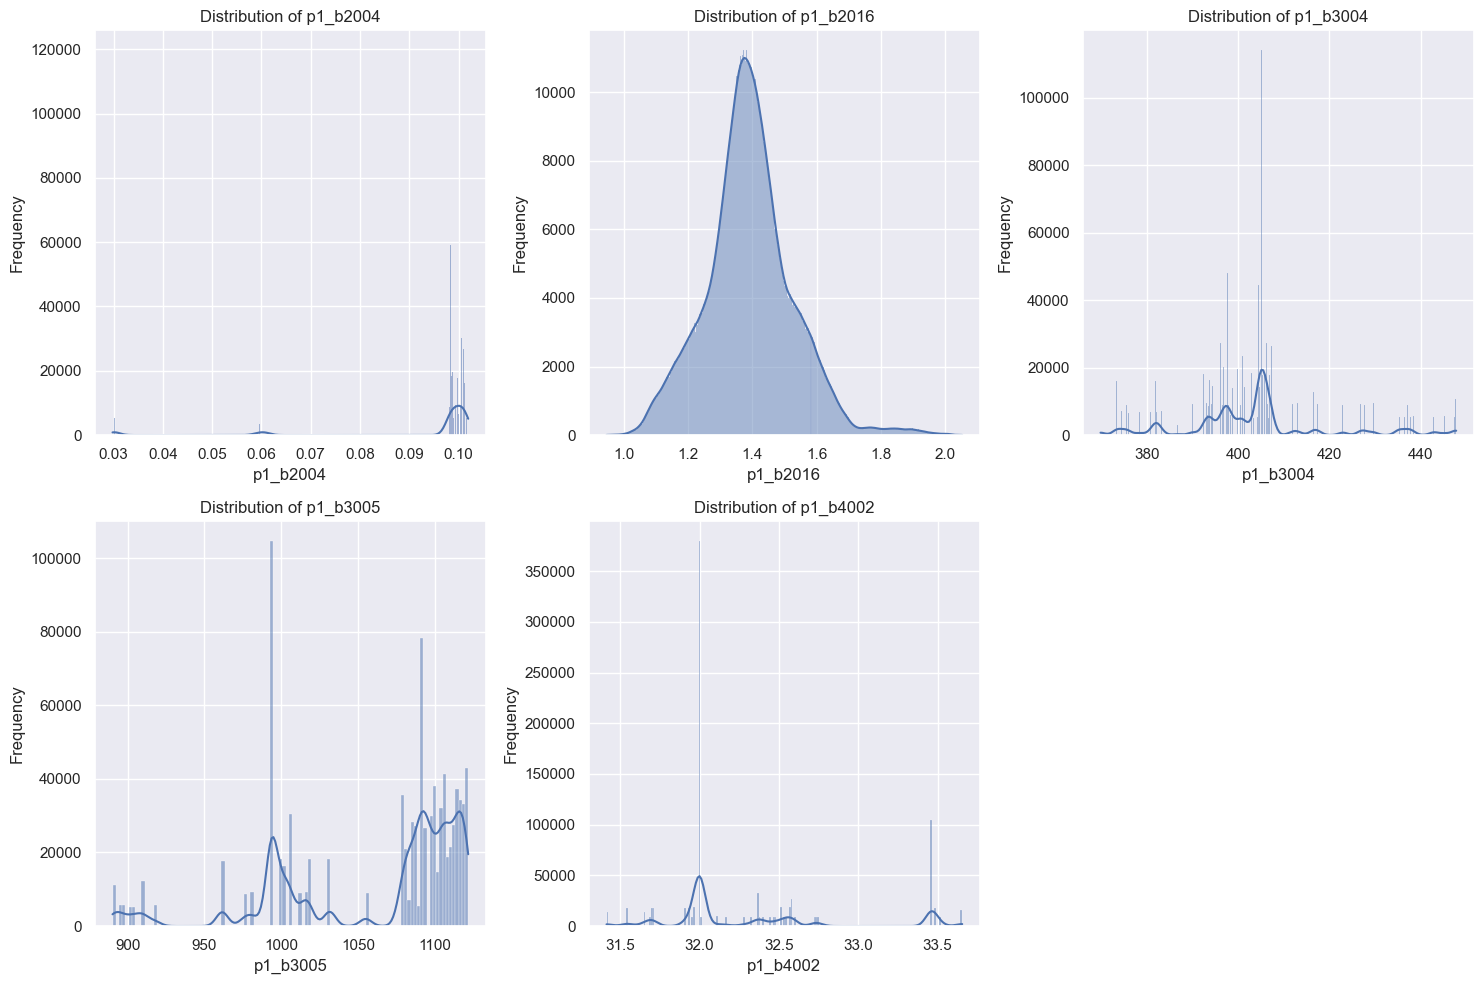

In [10]:
# Explore data distribution for a few features
sample_features = feature_cols[:5]  # Take first 5 features

plt.figure(figsize=(15, 10))
for i, feature in enumerate(sample_features):
    plt.subplot(2, 3, i+1)
    sns.histplot(train_df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

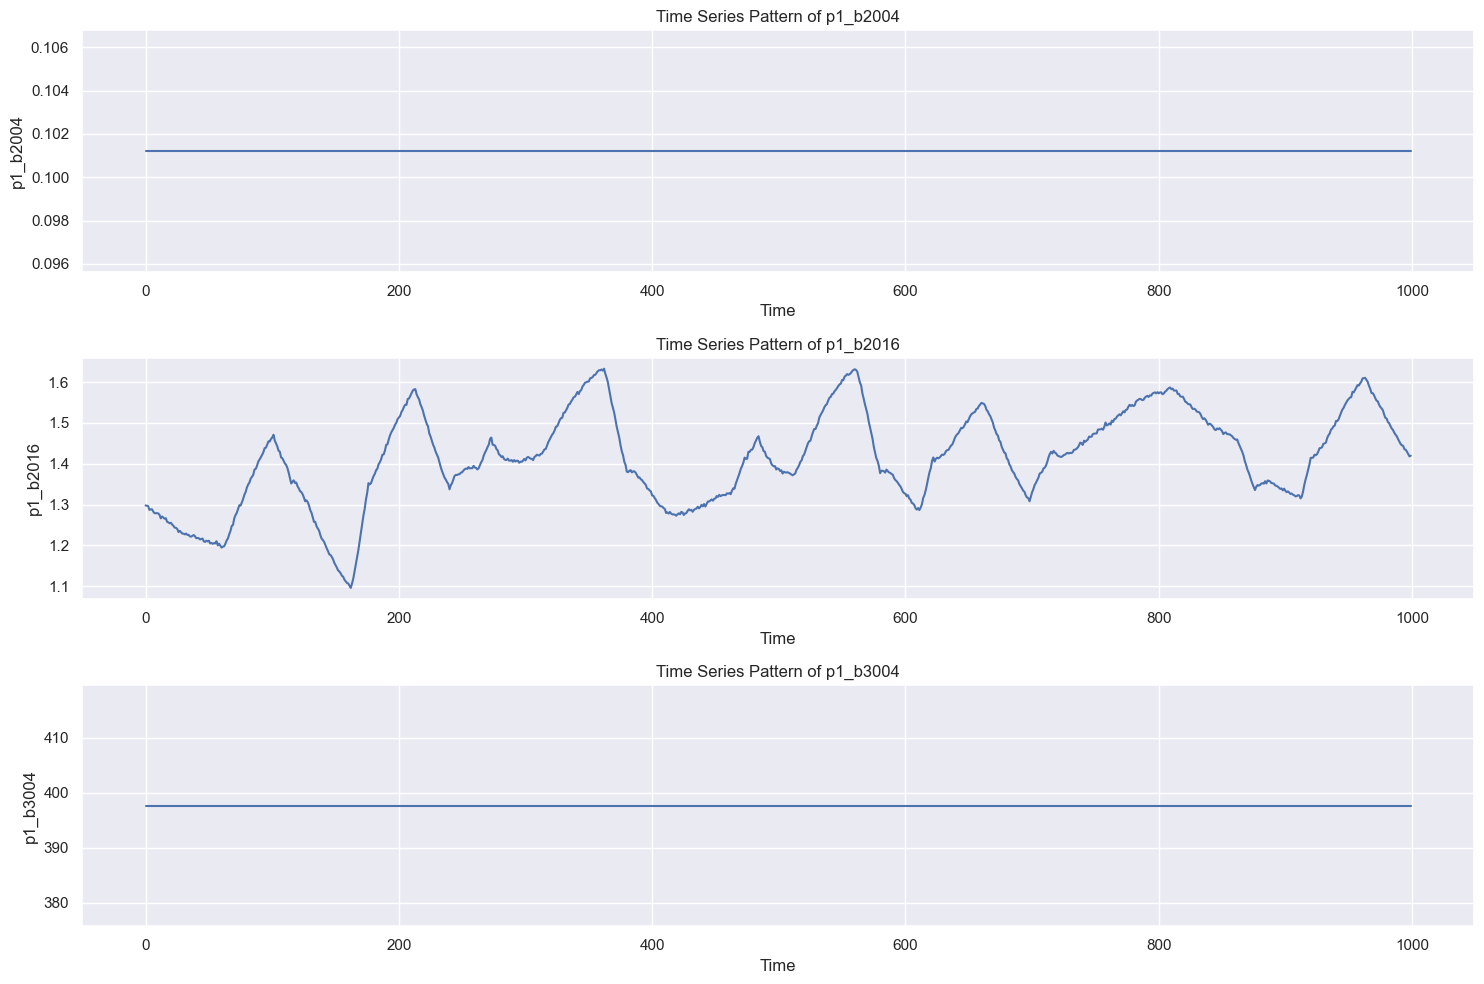

In [11]:
# Explore time series patterns for a few features
sample_features = feature_cols[:3]  # Take first 3 features
sample_size = 1000  # Take a sample for visualization

plt.figure(figsize=(15, 10))
for i, feature in enumerate(sample_features):
    plt.subplot(3, 1, i+1)
    plt.plot(train_df[feature].iloc[:sample_size])
    plt.title(f'Time Series Pattern of {feature}')
    plt.xlabel('Time')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

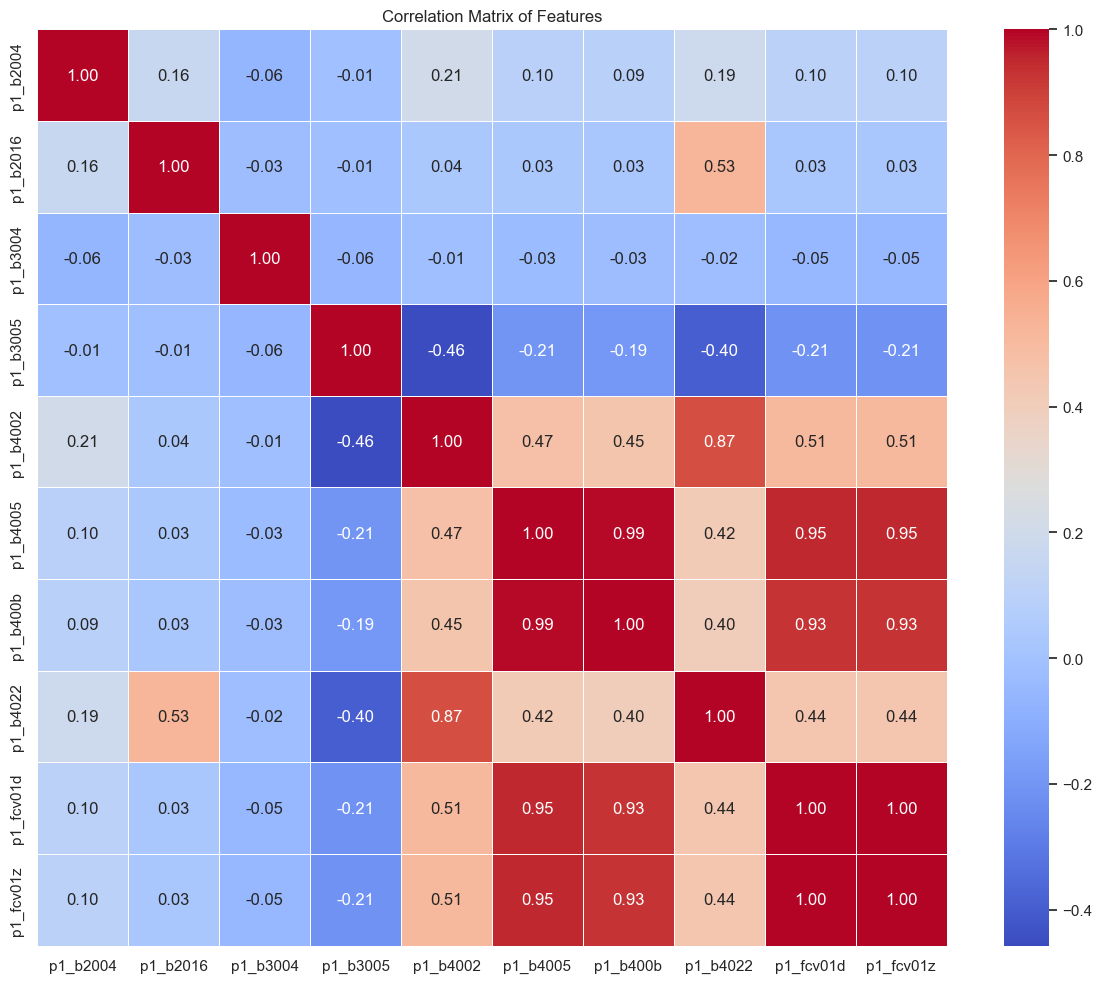

In [12]:
# Explore correlations between features
sample_features = feature_cols[:10]  # Take first 10 features for correlation analysis
correlation_matrix = train_df[sample_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.tight_layout()
plt.show()

In [13]:
# Explore test datasets
print("Test datasets:")
for name, df in data_loader.test_data.items():
    attack_count = df['attack'].sum()
    attack_percentage = (attack_count / len(df)) * 100
    print(f"  {name}: {df.shape[0]} rows, {df.shape[1]} columns, {attack_count} attacks ({attack_percentage:.2f}%)")

Test datasets:
  test1: 43201 rows, 84 columns, 629 attacks (1.46%)
  test2: 118801 rows, 84 columns, 3449 attacks (2.90%)
  test3: 108001 rows, 84 columns, 1535 attacks (1.42%)
  test4: 39601 rows, 84 columns, 1157 attacks (2.92%)
  test5: 92401 rows, 84 columns, 2177 attacks (2.36%)


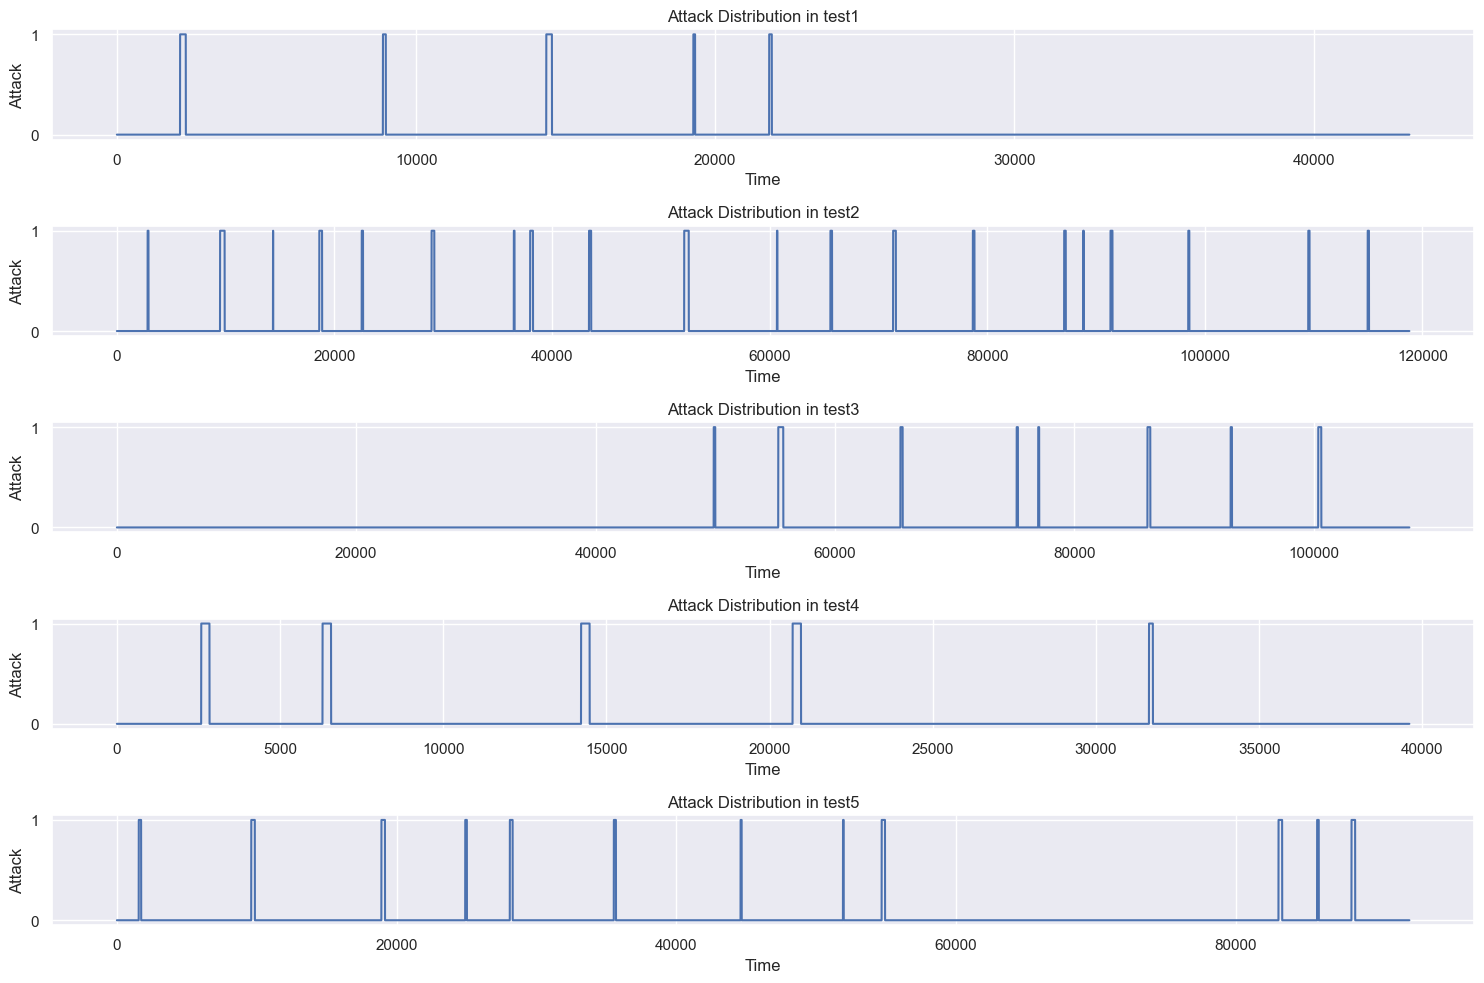

In [14]:
# Visualize attack distribution in test datasets
plt.figure(figsize=(15, 10))
for i, (name, df) in enumerate(data_loader.test_data.items()):
    plt.subplot(len(data_loader.test_data), 1, i+1)
    plt.plot(df['attack'])
    plt.title(f'Attack Distribution in {name}')
    plt.xlabel('Time')
    plt.ylabel('Attack')
    plt.yticks([0, 1])
plt.tight_layout()
plt.show()

In [15]:
# Save the merged training data for the next notebook
train_df.to_csv(os.path.join(OUTPUT_DIR, 'merged_train.csv'), index=False)
print(f"Saved merged training data to {os.path.join(OUTPUT_DIR, 'merged_train.csv')}")

Saved merged training data to hai-security-dataset/processed\merged_train.csv
